In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Set verbosity to avoid warnings
logging.set_verbosity_warning()

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Import wandb and set requirements (for logging purposes)
!pip install wandb
import wandb
wandb.require("service")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load the dataset and print the head
df = pd.read_csv('data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
# Handle missing values by dropping rows with NaN values
df = df.dropna()

# Remove duplicate rows
df = df.drop_duplicates()

# Check for any remaining missing values and duplicates
print(df.isnull().sum())
print(df.duplicated().sum())

Sentence     0
Sentiment    0
dtype: int64
0


In [ ]:
# Print random samples of each sentiment class
print(random.sample(list(df.loc[df.Sentiment == 'positive'].Sentence), 3))
print('\nNegative Sample Sentence:\n')
print(random.sample(list(df.loc[df.Sentiment == 'negative'].Sentence), 3))
print('\nNeutral Sample Sentence:\n')
print(random.sample(list(df.loc[df.Sentiment == 'neutral'].Sentence), 3))

['Brewer AB InBev seeks $275 bln tie-up with SABMiller', 'In the third quarter , net sales increased by 12 % year-on-year to EUR 159.5 million , or by 6 % at comparable currency rates growth .', 'That topped consensus forecasts for earnings of 0.21 euros a share .']

Negative Sample Sentence:

['Many of the commercial vessels had got stuck in the narrow Bay of Bothnia , where the ice is thicker , and around the Aaland islands .', 'Finnish airline Finnair is starting the temporary layoffs of cabin crews in February 2010 .', 'Cash flow from operations in January-December 2008 was a negative EUR 18.1 mn compared to EUR 39.0 mn in the corresponding period in 2007 .']

Neutral Sample Sentence:

["The reorganisation will be carried out by transferring HKScan Corporation 's production-related property , plant and equipment in Finland as well as its holdings in subsidiaries and associates to HKScan Finland Oy , a holding company wholly owned by HKScan Corporation .", 'ABN Amro Capital has agre

In [ ]:
# Define a function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a single string
    text = ' '.join(tokens)

    return text


In [ ]:
# Apply preprocessing to the 'Sentence' column
df['Cleaned_Sentence'] = df['Sentence'].apply(preprocess_text)

In [ ]:
df.head()

,Sentence,Sentiment,Cleaned_Sentence
0,The GeoSolutions technology will leverage Bene...,positive,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi lows 150 250 bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sales doubled...
3,According to the Finnish-Russian Chamber of Co...,neutral,according finnishrussian chamber commerce majo...
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sold remaining 224 percent...


<Axes: xlabel='Sentiment', ylabel='count'>

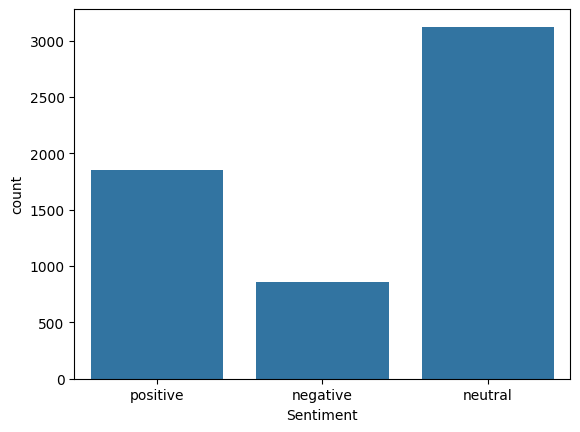

In [ ]:
# Visualize the distribution of sentiment labels
sns.countplot(x=df.Sentiment)

In [ ]:
# Encode the sentiment labels
encoder = LabelEncoder()
labels = encoder.fit_transform(df.Sentiment)
labels

array([2, 0, 2, ..., 1, 1, 2])

In [ ]:
# show the encoder classes
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

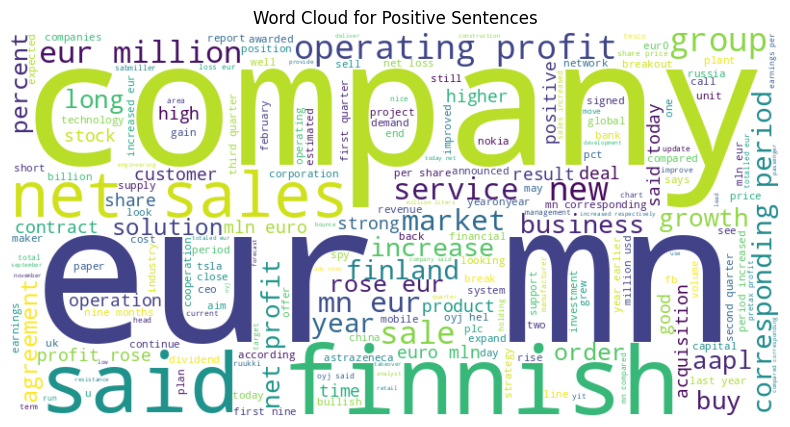

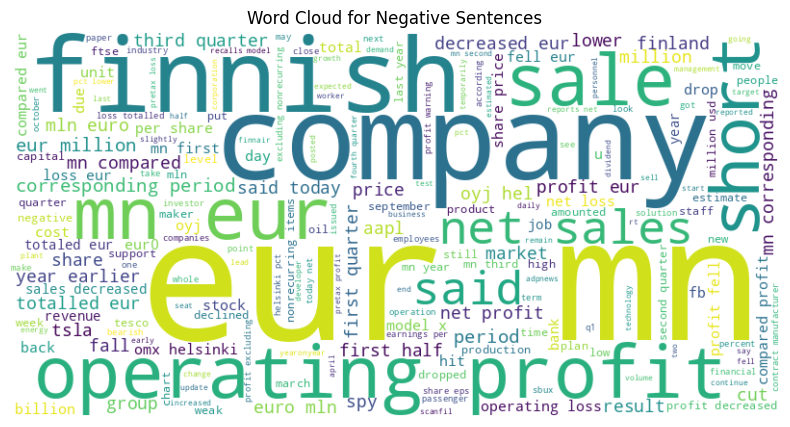

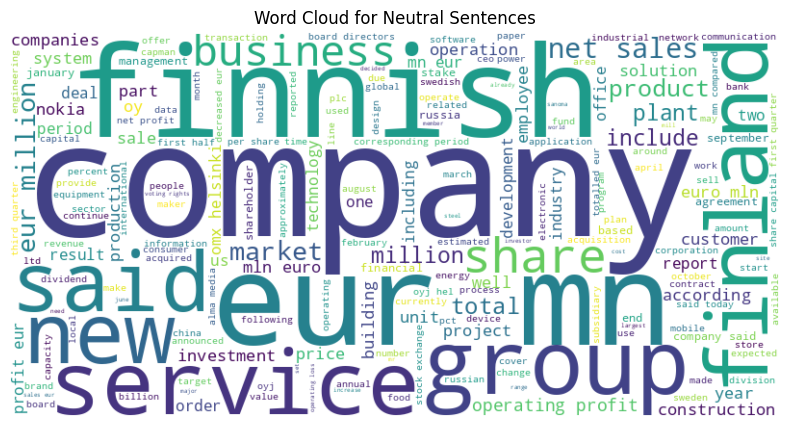

In [ ]:
# Word Cloud visualization for each sentiment category
def generate_wordcloud(sentiment_data, sentiment_label):
    combined_text = ' '.join(sentiment_data)  # Combine all sentences
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=200, colormap='viridis').generate(combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment_label} Sentences')
    plt.show()

for sentiment, label in [('positive', 'Positive'), ('negative', 'Negative'), ('neutral', 'Neutral')]:
    sentiment_sentences = df[df['Sentiment'] == sentiment]['Cleaned_Sentence']
    generate_wordcloud(sentiment_sentences, label)


In [ ]:
# Split data into training (80%), validation (10%), and test (10%) sets
X_train, X_val_test, y_train, y_val_test = train_test_split(df.Cleaned_Sentence.values, labels, test_size=.2, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=.5, random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((4668,), (4668,), (584,), (584,), (584,), (584,))

In [ ]:
# Set parameters for the model
MAX_LEN = 50
BATCH_SIZE = 16
device = torch.device('cuda')
lr_rate = 2e-5
EPOCH = 5
num_classes = 3

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Dataset class for handling input sentences
class FinancialDataset(Dataset):
    def __init__(self, sentences, target, tokenizer, max_len):
        self.sentences = sentences
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sentences)
    def __getitem__(self,idx):
        sentence = self.sentences[idx]
        # encode input sentence
        encoding = tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.target[idx],dtype=torch.long)
        }

In [ ]:
# Create data loaders for training, validation, and testing
train_dataset = FinancialDataset(X_train, y_train, tokenizer, MAX_LEN)
train_dataloader = DataLoader(train_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset = FinancialDataset(X_val, y_val, tokenizer, MAX_LEN)
val_dataloader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset = FinancialDataset(X_test, y_test, tokenizer, MAX_LEN)

In [ ]:
# check the output of dataloader
next(iter(train_dataset))

{'input_ids': tensor([  101,  2192,  4502, 18447,  2098, 24604,  2613,  8574, 29461, 13510,
          4293, 27487,  2146,  2423, 27487,  2784,  2327,  3953,  2690,  8103,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'targets': tensor(1)}

In [ ]:
# Create data loaders for training, validation, and testing
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
# Metrics class for tracking loss and accuracy
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count

# Function to calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

# Log class for recording training and validation metrics
class Log(object):
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [ ]:
# Training function
def train_fn(data_loader, model, optimizer, criterion,device, epoch):
    model.train()

    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()

        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)

        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

# Validation function
def eval_fn(data_loader, model,criterion,device, epoch):
    model.eval()

    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()

        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs, targets)
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets)

        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

In [ ]:
# Function to run the training and validation process
def run():
    # Load pretrained model
    model = SentimentClassifier(num_classes)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    best_loss = 10**5
    log = Log()
    for epoch in range(0,EPOCH):
        train_metrics = train_fn(train_dataloader, model, optimizer, criterion, device, epoch)
        val_metrics = eval_fn(val_dataloader, model, criterion, device, epoch)
        log.append(train_metrics,val_metrics)
        scheduler.step(val_metrics.avg_loss)
        # Check if val_loss is less than best_loss
        if val_metrics.avg_loss < best_loss:
            # Update best loss
            best_loss = val_metrics.avg_loss
            # Save model
            torch.save(model.state_dict(), f'best.pth')
    return log

In [ ]:
log = run()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 37/37 [00:01<00:00, 19.48it/s, accuracy=0.747, epoch=5, loss=0.796]


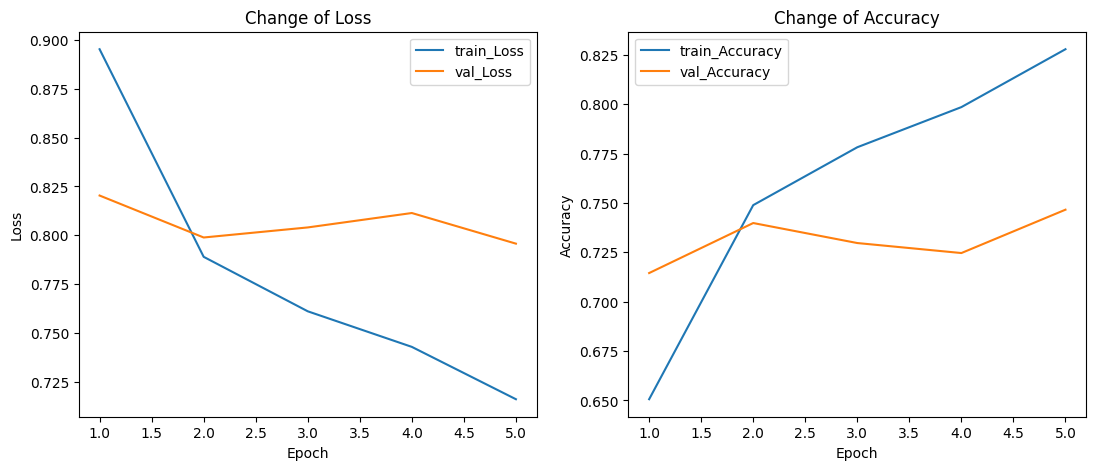

In [ ]:
# Plot the training and validation loss and accuracy
fig, axs = plt.subplots(1,2,figsize=(13,5))

def plot_log(ax, train_value, val_value, label):
    sns.lineplot(y=train_value,x=range(1,EPOCH+1),ax=ax,label=f'train_{label}')
    sns.lineplot(y=val_value,x=range(1,EPOCH+1),ax=ax,label=f'val_{label}')
    ax.set_title(f'Change of {label}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)

plot_log(axs[0],log.train_loss,log.val_loss,'Loss')
plot_log(axs[1],log.train_accuracy,log.val_accuracy,'Accuracy')

In [ ]:
# Load the best model and evaluate on the test set
model = SentimentClassifier(num_classes)
model.load_state_dict(torch.load('./best.pth'))

<All keys matched successfully>

In [ ]:
# Test function
def test_fn(dataset, model, device):
    model = model.to(device)
    model.eval()

    labels = []
    predictions = []
    tk0 = tqdm(dataset, total=len(dataset))
    for step, inputs in enumerate(tk0):
        input_ids = torch.unsqueeze(inputs['input_ids'],dim=0)
        attention_mask = torch.unsqueeze(inputs['attention_mask'],dim=0)
        targets = torch.unsqueeze(inputs['targets'],dim=0)
        input_ids = input_ids.to(device, non_blocking=True).long()
        attention_mask = attention_mask.to(device, non_blocking=True).long()
        targets = targets.to(device, non_blocking=True).long()
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        pred = torch.argmax(torch.softmax(outputs, dim=1),dim=1)

        labels.append(targets.item())
        predictions.append(pred.item())
    return labels, predictions

In [ ]:
# Predict test dataset
labels, preds = test_fn(test_dataset, model, device)

100%|██████████| 584/584 [00:07<00:00, 77.42it/s]


In [ ]:
print(f'Label\t\t:{labels[:10]}')
print(f'Prediction\t:{preds[:10]}')

Label		:[2, 2, 0, 2, 1, 1, 1, 1, 2, 1]
Prediction	:[2, 1, 1, 2, 1, 1, 2, 1, 2, 1]


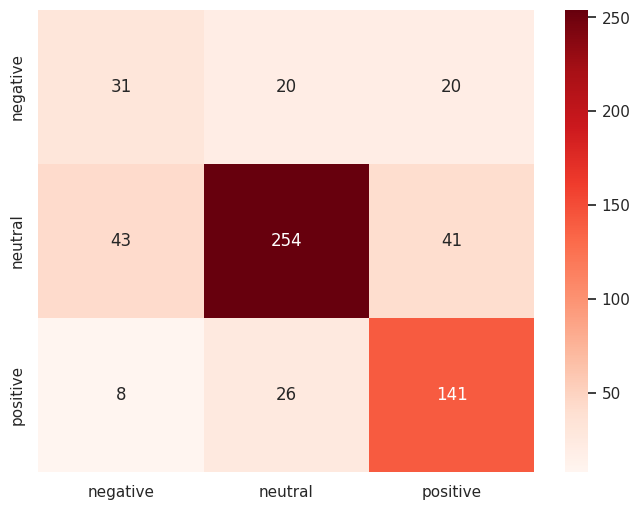

In [ ]:
# Visualize predictions
sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
cf_matrix = confusion_matrix(labels, preds)
sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=encoder.classes_,yticklabels=encoder.classes_);

In [ ]:
label_preds = encoder.inverse_transform(preds)
label_targets = encoder.inverse_transform(labels)

In [ ]:
print(classification_report(label_targets,label_preds))


              precision    recall  f1-score   support

    negative       0.38      0.44      0.41        71
     neutral       0.85      0.75      0.80       338
    positive       0.70      0.81      0.75       175

    accuracy                           0.73       584
   macro avg       0.64      0.66      0.65       584
weighted avg       0.75      0.73      0.73       584

